In [1]:
!git clone https://github.com/nguyenbim/Annual_power_consumption_forecasting

Cloning into 'Annual_power_consumption_forecasting'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 6), reused 16 (delta 4), pack-reused 0
Receiving objects: 100% (26/26), 2.64 MiB | 6.61 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
!gdown 1YD1p5oCYU_z9EJVPrVZvJk59b8Yus0xk
!gdown 1eXraWCg4kQPanV0hRiFyO-MKeq79U2FJ
!gdown 1ajNlmEI41CIxrZedDUtFLqfLtVT7cDb5
!gdown 1Gx4Ye6se5GsAbqXeB8XEW1yJDGVtNibe

Downloading...
From: https://drive.google.com/uc?id=1YD1p5oCYU_z9EJVPrVZvJk59b8Yus0xk
To: /content/global-data-on-sustainable-energy.csv
100% 525k/525k [00:00<00:00, 7.63MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eXraWCg4kQPanV0hRiFyO-MKeq79U2FJ
To: /content/scaler_pe_all.joblib
100% 2.38k/2.38k [00:00<00:00, 8.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ajNlmEI41CIxrZedDUtFLqfLtVT7cDb5
To: /content/best_lstm_pe_all_feat.h5
100% 41.1M/41.1M [00:00<00:00, 79.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Gx4Ye6se5GsAbqXeB8XEW1yJDGVtNibe
To: /content/sample_df.csv
100% 97.3k/97.3k [00:00<00:00, 71.8MB/s]


In [4]:
df = pd.read_csv('global-data-on-sustainable-energy.csv')

In [5]:
df_fillna = df.copy()

In [6]:
df_fillna.drop(['Financial flows to developing countries (US $)', 'Renewables (% equivalent primary energy)'], axis=1, inplace=True)

In [7]:
df_fillna.drop(df_fillna.columns[-4:], axis=1, inplace=True)

In [8]:
df_fillna = df_fillna[df_fillna['Entity'] != 'French Guiana']

In [9]:
def impute_missing_values_by_entity_first_step(df_fillna):
    df = df_fillna.copy()
    for entity in df['Entity'].unique():
        entity_df = df[df['Entity'] == entity]
        # fill all nan values in the beginning and final of all columns with interpolate linear, limit_direction both, limit_area outside
        entity_df = entity_df.interpolate(limit_direction='both', limit_area='outside')
        # fill all nan values in the middle of all columns with interpolate linear, limit_direction both, limit_area inside
        entity_df = entity_df.interpolate(limit_direction='both', limit_area='inside')
        df[df['Entity'] == entity] = entity_df
    df = df.reset_index(drop=True)
    return df

df_fillna_first_step = impute_missing_values_by_entity_first_step(df_fillna)

In [10]:
df_fillna_first_step.drop('Renewable-electricity-generating-capacity-per-capita', axis=1, inplace=True)
df_fillna_first_step.dropna(subset=['Value_co2_emissions_kt_by_country'], inplace=True)

In [11]:
df_fillna_first_step.dropna(inplace=True)

In [12]:
df_pe_fillna = df_fillna_first_step.copy()

In [13]:
df_pe_fillna.rename(columns={'Value_co2_emissions_kt_by_country': 'CO2', 'Access to electricity (% of population)': 'AE', 'Access to clean fuels for cooking': 'AF', 'Renewable energy share in the total final energy consumption (%)': 'RE',
                                'Electricity from fossil fuels (TWh)': 'EF', 'Electricity from nuclear (TWh)': 'EN', 'Electricity from renewables (TWh)': 'ER', 'Low-carbon electricity (% electricity)': 'EC',
                                'Primary energy consumption per capita (kWh/person)': 'PE', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'EI', 'gdp_growth': 'GG', 'gdp_per_capita': 'GC'}, inplace=True)

df_pe_fillna.head()

,Entity,Year,AE,AF,RE,EF,EN,ER,EC,PE,EI,CO2,GG,GC
0,Afghanistan,2000,1.613591,6.2,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,8.832278,179.426579
1,Afghanistan,2001,4.074574,7.2,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,8.832278,179.426579
2,Afghanistan,2002,9.409158,8.2,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,8.832278,179.426579
3,Afghanistan,2003,14.738506,9.5,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,8.832278,190.683814
4,Afghanistan,2004,20.064968,10.9,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,1.414118,211.382074


In [14]:
test_ts = pd.read_csv('/content/sample_df.csv')

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from joblib import load

# Tải lại scaler từ tệp
scaler = load('scaler_pe_all.joblib')



In [16]:
import tensorflow as tf
from keras import backend as K

def custom_weighted_mse(y_true, y_pred):
    # Tính squared error cho mỗi dự đoán
    squared_error = tf.keras.backend.square(y_true - y_pred)

    # Tạo trọng số: giá trị ngược của thời gian dự đoán, nhân với một hằng số
    weights = 1 / (tf.range(1, squared_error.shape[1] + 1, dtype=tf.float32)*2)*1000

    # Nhân squared error với trọng số
    weighted_squared_error = squared_error * weights

    # Tính mean của squared error cho mỗi mốc thời gian
    loss = tf.keras.backend.mean(weighted_squared_error, axis=1)

    # Tính mean của các mean squared error cho từng mốc thời gian
    loss = tf.keras.backend.mean(loss)

    return loss

In [18]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
import keras
from keras.models import load_model
custom_objects = {'custom_weighted_mse':custom_weighted_mse}
with keras.saving.custom_object_scope(custom_objects):
    final_model = keras.models.load_model("/content/best_lstm_pe_all_feat.h5")

In [20]:
# predict for future 5 time steps, choose 3 Entity to predict
# 3 lags is data from 2020,2019,2018

def predict_future(df_pe_fillna, test_ts, model, scaler, entity_idx):
    df_unseen = test_ts.copy()
    entities = df_unseen['Entity'].unique()
    list_cols = ['AE', 'AF', 'RE', 'EF', 'EN', 'ER', 'EC', 'PE', 'EI', 'CO2', 'GG', 'GC']
   # each entity only keep 1st row
    for entity in entities:
        df_unseen.drop(df_unseen[df_unseen['Entity'] == entity].index[1:], inplace=True)
        if(entity == entities[entity_idx]):
          df_entity = df_pe_fillna.loc[(df_pe_fillna['Entity'] == entity)]
          for col in list_cols:
              # values of df_unseen at entity and col+'_t-2' is the same as df_pe_fillna at entity and col in 2018
              df_unseen.loc[df_unseen['Entity'] == entity, col+'_t-2'] = df_entity.iloc[-3][col]
              # values of df_unseen at entity and col+'_t-1' is the same as df_pe_fillna at entity and col in 2019
              df_unseen.loc[df_unseen['Entity'] == entity, col+'_t-1'] = df_entity.iloc[-2][col]
              # values of df_unseen at entity and col+'_t' is the same as df_pe_fillna at entity and col in 2020
              df_unseen.loc[df_unseen['Entity'] == entity, col+'_t'] = df_entity.iloc[-1][col]

    # scaler
    df_unseen[['AE_t', 'AE_t-1', 'AE_t-2', 'AF_t', 'AF_t-1', 'AF_t-2',
       'RE_t', 'RE_t-1', 'RE_t-2', 'EF_t', 'EF_t-1', 'EF_t-2', 'EN_t',
       'EN_t-1', 'EN_t-2', 'ER_t', 'ER_t-1', 'ER_t-2', 'EC_t', 'EC_t-1',
       'EC_t-2', 'PE_t', 'PE_t-1', 'PE_t-2', 'EI_t', 'EI_t-1', 'EI_t-2',
       'CO2_t', 'CO2_t-1', 'CO2_t-2', 'GG_t', 'GG_t-1', 'GG_t-2', 'GC_t',
       'GC_t-1', 'GC_t-2', 'PE_t+1', 'PE_t+2', 'PE_t+3', 'PE_t+4', 'PE_t+5']] = scaler.transform(df_unseen[['AE_t', 'AE_t-1', 'AE_t-2', 'AF_t', 'AF_t-1', 'AF_t-2',
                                                                                                                'RE_t', 'RE_t-1', 'RE_t-2', 'EF_t', 'EF_t-1', 'EF_t-2', 'EN_t',
                                                                                                                'EN_t-1', 'EN_t-2', 'ER_t', 'ER_t-1', 'ER_t-2', 'EC_t', 'EC_t-1',
                                                                                                                'EC_t-2', 'PE_t', 'PE_t-1', 'PE_t-2', 'EI_t', 'EI_t-1', 'EI_t-2',
                                                                                                                'CO2_t', 'CO2_t-1', 'CO2_t-2', 'GG_t', 'GG_t-1', 'GG_t-2', 'GC_t',
                                                                                                                'GC_t-1', 'GC_t-2', 'PE_t+1', 'PE_t+2', 'PE_t+3', 'PE_t+4', 'PE_t+5']])
    df_unseen_t = df_unseen[['AE_t','AF_t','RE_t','EF_t','EN_t','ER_t','EC_t','PE_t','EI_t','CO2_t','GG_t','GC_t','Entity']]
    df_unseen_t_1 = df_unseen[['AE_t-1','AF_t-1','RE_t-1','EF_t-1','EN_t-1','ER_t-1','EC_t-1','PE_t-1','EI_t-1','CO2_t-1','GG_t-1','GC_t-1','Entity']]
    df_unseen_t_2 = df_unseen[['AE_t-2','AF_t-2','RE_t-2','EF_t-2','EN_t-2','ER_t-2','EC_t-2','PE_t-2','EI_t-2','CO2_t-2','GG_t-2','GC_t-2','Entity']]

    df_unseen_t = pd.get_dummies(df_unseen_t, columns=['Entity'],drop_first=True).astype('float32')
    df_unseen_t_1 = pd.get_dummies(df_unseen_t_1, columns=['Entity'], drop_first = True).astype('float32')
    df_unseen_t_2 = pd.get_dummies(df_unseen_t_2, columns=['Entity'], drop_first = True).astype('float32')

    X_unseen = np.concatenate([df_unseen_t_2.values.reshape(df_unseen.shape[0], 1, df_unseen_t.shape[1]), df_unseen_t_1.values.reshape(df_unseen.shape[0], 1, df_unseen_t.shape[1]), df_unseen_t.values.reshape(df_unseen.shape[0], 1, df_unseen_t.shape[1])], axis=1)
    print(X_unseen.shape)
    y_unseen = model.predict(X_unseen)
    print(y_unseen.shape)
    df_unseen['PE_t+1_pred'] = y_unseen[:,0]
    df_unseen['PE_t+2_pred'] = y_unseen[:,1]
    df_unseen['PE_t+3_pred'] = y_unseen[:,2]
    df_unseen['PE_t+4_pred'] = y_unseen[:,3]
    df_unseen['PE_t+5_pred'] = y_unseen[:,4]

    df_unseen[['AE_t', 'AE_t-1', 'AE_t-2', 'AF_t', 'AF_t-1', 'AF_t-2',
       'RE_t', 'RE_t-1', 'RE_t-2', 'EF_t', 'EF_t-1', 'EF_t-2', 'EN_t',
       'EN_t-1', 'EN_t-2', 'ER_t', 'ER_t-1', 'ER_t-2', 'EC_t', 'EC_t-1',
       'EC_t-2', 'PE_t', 'PE_t-1', 'PE_t-2', 'EI_t', 'EI_t-1', 'EI_t-2',
       'CO2_t', 'CO2_t-1', 'CO2_t-2', 'GG_t', 'GG_t-1', 'GG_t-2', 'GC_t',
       'GC_t-1', 'GC_t-2', 'PE_t+1_pred', 'PE_t+2_pred', 'PE_t+3_pred', 'PE_t+4_pred', 'PE_t+5_pred']] = scaler.inverse_transform(df_unseen[['AE_t', 'AE_t-1', 'AE_t-2',
                                                                                                                                                   'AF_t', 'AF_t-1', 'AF_t-2',
                                                                                                                'RE_t', 'RE_t-1', 'RE_t-2', 'EF_t', 'EF_t-1', 'EF_t-2', 'EN_t',
                                                                                                                'EN_t-1', 'EN_t-2', 'ER_t', 'ER_t-1', 'ER_t-2', 'EC_t', 'EC_t-1',
                                                                                                                'EC_t-2', 'PE_t', 'PE_t-1', 'PE_t-2', 'EI_t', 'EI_t-1', 'EI_t-2',
                                                                                                                'CO2_t', 'CO2_t-1', 'CO2_t-2', 'GG_t', 'GG_t-1', 'GG_t-2', 'GC_t',
                                                                                                                'GC_t-1', 'GC_t-2', 'PE_t+1_pred',
                                                                                                                  'PE_t+2_pred', 'PE_t+3_pred', 'PE_t+4_pred', 'PE_t+5_pred']])

    return df_unseen


df_unseen = predict_future(df_pe_fillna, test_ts, final_model, scaler,146)

df_unseen

(147, 3, 158)
5/5 [==============================] - 1s 5ms/step
(147, 5, 1)


,Entity,AE_t,AE_t-1,AE_t-2,AF_t,AF_t-1,AF_t-2,RE_t,RE_t-1,RE_t-2,...,PE_t+1,PE_t+2,PE_t+3,PE_t+4,PE_t+5,PE_t+1_pred,PE_t+2_pred,PE_t+3_pred,PE_t+4_pred,PE_t+5_pred
0,Afghanistan,42.400000,36.051010,30.718690,16.7,15.3,13.85,21.17,28.78,31.89,...,-0.663428,-0.659324,-0.655718,-0.663726,-0.673080,447.165012,393.531046,451.588273,605.124586,657.308194
2,Algeria,98.889610,98.912080,98.934010,98.5,98.2,98.00,0.58,0.44,0.47,...,-0.389156,-0.379781,-0.368206,-0.356602,-0.369549,10999.198188,11356.107113,11921.825897,12332.356651,12486.324868
4,Angola,30.586895,29.527786,28.470550,42.9,42.6,41.90,62.13,68.38,61.92,...,-0.617288,-0.609394,-0.604343,-0.603640,-0.604306,2400.255480,2513.417949,2609.165515,2734.951675,2767.658217
6,Antigua and Barbuda,100.000000,92.200000,98.037100,100.0,100.0,100.00,0.00,0.00,0.00,...,0.193780,0.198433,0.228734,0.190289,0.183447,33447.501740,33816.478277,33794.058732,33624.274998,33339.173224
8,Argentina,96.863846,96.653500,96.442635,97.5,97.2,96.45,9.64,9.29,10.82,...,-0.132615,-0.116840,-0.114934,-0.136218,-0.118075,20499.860408,21183.097782,21713.687654,22086.566708,22236.771584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Uruguay,98.784355,98.692635,98.505424,100.0,100.0,100.00,44.09,43.20,37.60,...,-0.222111,-0.207122,-0.219107,-0.219911,-0.197198,16143.643727,17041.243999,17964.092032,18476.415547,18669.874594
286,Uzbekistan,99.700000,99.630104,99.593270,84.2,83.9,83.60,1.02,0.78,0.72,...,-0.111761,-0.122728,-0.131130,-0.173519,-0.140999,21166.634474,20402.443853,20019.076242,19766.723433,19543.393240
288,Vanuatu,26.440000,31.094734,29.310175,14.5,14.7,15.10,63.75,64.26,64.06,...,-0.622431,-0.626370,-0.621035,-0.624965,-0.617026,1509.191241,1712.061206,1845.304520,2011.524948,2072.029981
290,Zambia,23.321308,20.300000,18.500000,15.7,15.3,15.10,88.68,89.28,89.20,...,-0.608149,-0.616760,-0.619819,-0.625815,-0.626736,2229.225902,2363.329317,2401.616041,2492.805388,2507.818170


In [21]:
def predict_entity(entity_idx, df_unseen):
    entity = df_unseen['Entity'].unique()[entity_idx]
    df_entity = df_unseen[df_unseen['Entity'] == entity]
    predictions = df_entity[['PE_t','PE_t+1_pred', 'PE_t+2_pred', 'PE_t+3_pred', 'PE_t+4_pred', 'PE_t+5_pred']].values[0]
    pasts = df_entity[['PE_t-2', 'PE_t-1', 'PE_t']].values[0]

    plt.plot(list(range(2, 8)), predictions, color='b', label='predict')
    plt.plot(list(range(0, 3)), pasts, color='r', label='past')


    # chage x-axis to year
    plt.xticks(list(range(0, 8)), [str(year) for year in range(2018, 2026)])
    title = 'Entity: ' + entity
    plt.title(title)
    plt.axvline(x=2, color='g', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Power consumption')
    plt.legend()
    plt.show()

    print(f'Entity: {entity}')
    print(f'PE 2021: {predictions[1]}')
    print(f'PE 2022: {predictions[2]}')
    print(f'PE 2023: {predictions[3]}')
    print(f'PE 2024: {predictions[4]}')
    print(f'PE 2025: {predictions[5]}')


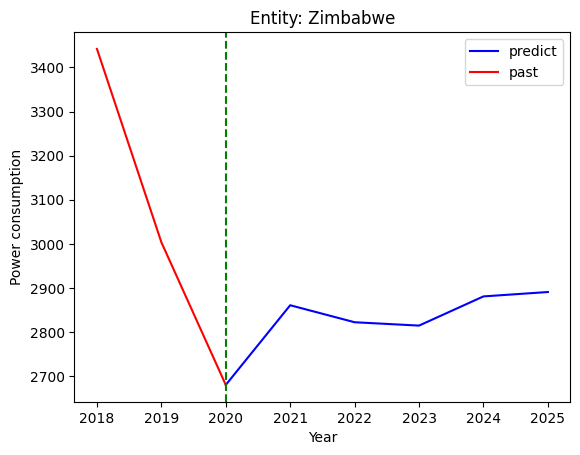

Entity: Zimbabwe
PE 2021: 2860.801182468025
PE 2022: 2822.250701397741
PE 2023: 2814.6385979560946
PE 2024: 2880.829452259444
PE 2025: 2890.781951214991


In [22]:
predict_entity(146, df_unseen)